In [1]:
import numpy as np
import pandas as pd

In [2]:
import pickle
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, MultiTaskElasticNetCV, ElasticNetCV, LogisticRegression
from sklearn.metrics import f1_score, accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from xgboost import XGBClassifier, XGBRegressor

import seaborn as sns

from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.svm import SVC

In [3]:
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 1

In [5]:
import logging
logger = logging.getLogger('causalml')
logging.basicConfig(level=logging.INFO)

In [6]:
data_path='../Processed/final/'
save_path='../Processed/final/'

# Data processing

In [7]:
(Y_train, T_train, X_train, W_train)=pickle.load(open(data_path+'YTXW_train.pkl','rb'))
(Y_test, T_test, X_test, W_test)=pickle.load(open(data_path+'YTXW_test.pkl','rb'))
(Y_val, T_val, X_val, W_val)=pickle.load(open(data_path+'YTXW_val.pkl','rb'))

In [8]:
le_dx=pickle.load(open(data_path+'le_dx.pkl','rb'))
le_patid=pickle.load(open(data_path+'le_patid.pkl','rb'))
selected_patient_feature=['age_onset','obs_win','female']+['race__'+c for c in ['A','B','H','U','W']]
rx2id = pickle.load(open(data_path+'drug_dict.pkl', 'rb'))

In [9]:
from sklearn import preprocessing

def prepare(y, t, w, x, rx2id, target):
    patid_temp = list(w['patid'].unique())
    temp_le = preprocessing.LabelEncoder()
    temp_le.fit(list(patid_temp))
    w['row_idx'] = temp_le.transform(w['patid'])
    
    w_sparse = csr_matrix((w['log_count'], (w['row_idx'], w['phecode3'])))
    w = w_sparse.toarray()
    
    x_temp = np.concatenate((w, x.values), axis=1)
    
    treatment_train = [0] * len(t)
    temp_index = t.index
    idx = 0

    def get_classes(value):
        return [k for k, v in rx2id.items() if v == value]

    for i in temp_index:
        classes = t.loc[i, 'antiasthma']
        if (classes != target):
            treatment_train[idx] = 'control'
        else:
            treatment_train[idx] = 'treatment'
        idx += 1
        
    treatment = pd.DataFrame(treatment_train)
    treatment.index = temp_index
    treatment.columns = ['treatment']
    
    y = pd.DataFrame(y)
    feature_df = pd.DataFrame(x_temp)
    feature_df.index = y.index
    
    df = pd.concat([y, treatment, t, feature_df], axis=1)
    df.index = np.arange(0, len(df))
    return df

In [10]:
target = 5
df_val0 = prepare(Y_val, T_val, W_val, X_val, rx2id, target)
df_test0 = prepare(Y_test, T_test, W_test, X_test, rx2id, target)
df_train0 = prepare(Y_train, T_train, W_train, X_train, rx2id, target)

In [11]:
x_train0 = df_train0.iloc[:, 5:]
x_test0 = df_test0.iloc[:, 5:]
x_val0 = df_val0.iloc[:, 5:]

# Benchmark

In [12]:
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.metrics import plot_gain, auuc_score
from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseSClassifier, BaseTClassifier, BaseXClassifier, BaseRClassifier
from causalml.feature_selection.filters import FilterSelect

from causalml.propensity import GradientBoostedPropensityModel
from causalml.propensity import compute_propensity_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.linear_model import ElasticNet


from causalml.feature_selection.filters import FilterSelect
from causalml.metrics import plot_gain, auuc_score

In [13]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## Feature selection for propensity scores

In [14]:
t = df_train0['treatment']
treatment = [0] * len(t)
for i in range(len(t)):
    if t[i] == 'control':
        treatment[i] = 0
    else:
        treatment[i] = 1

In [15]:
t_test = df_test0['treatment']
treatment_test = [0] * len(t_test)
for i in range(len(t_test)):
    if t_test[i] == 'control':
        treatment_test[i] = 0
    else:
        treatment_test[i] = 1 

In [16]:
t_val = df_val0['treatment']
treatment_val = [0] * len(t_val)
for i in range(len(t_val)):
    if t_val[i] == 'control':
        treatment_val[i] = 0
    else:
        treatment_val[i] = 1 

### L1 based feature selection

In [17]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
lsvc = LinearSVC(C=0.1, penalty="l1", dual=False).fit(x_train0,treatment)
model = SelectFromModel(lsvc, prefit=True)
x_new = model.transform(x_train0)

In [18]:
x_train0.shape, x_new.shape

((6771, 249), (6771, 207))

In [19]:
x_new_val = model.transform(x_val0)

### Logistic regression

In [20]:
glm = LogisticRegression(max_iter = 3000)
glm.fit(x_train0, treatment)
t_pred_p = glm.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5538050684211843

In [21]:
x_new_val.shape, x_new.shape

((2257, 207), (6771, 207))

### Random Forest

In [17]:
rf = RandomForestClassifier(max_depth=6, random_state=1105)
rf.fit(x_train0, treatment)
t_pred_p = rf.predict_proba(x_val0)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5773767084448669

In [23]:
rf = RandomForestClassifier(max_depth=6, random_state=1105)
rf.fit(x_new, treatment)
t_pred_p = rf.predict_proba(x_new_val)
lr_probs = t_pred_p[:, 1]
roc_auc_score(treatment_val, lr_probs)

0.5655233949582635

## Feature selection for meta-learners

In [18]:
y_test = df_test0['adrd']
l_test = len(x_test0)
score = rf.predict_proba(x_test0)
e_test = {t: score[0:l_test, t] for t in np.unique(treatment_test)}
xgb_plugin1 = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb_plugin0 = XGBClassifier(max_depth=6, random_state=1108, n_estimators=100)
x0 = df_train0.loc[df_train0['treatment'] == 'control', 0:248]
y0 = df_train0.loc[df_train0['treatment'] == 'control', 'adrd']
xgb_plugin0.fit(x0, y0)
x1 = df_train0.loc[df_train0['treatment'] == 'treatment', 0:248]
y1 = df_train0.loc[df_train0['treatment'] == 'treatment', 'adrd']
y_pred1 = xgb_plugin1.fit(x1, y1)
y_pred0 = xgb_plugin0.predict(x_test0)
y_pred1 = xgb_plugin1.predict(x_test0)
t_plugin = y_pred1 - y_pred0
ps = rf.predict_proba(x_test0)[:, 1]
a = (treatment_test - ps)
ident = np.array([1]*len(ps))
c = (ps*(ident-ps))
b = np.array([2]*len(treatment_test))*treatment_test*(treatment_test-ps) / c

In [20]:
filter_f = FilterSelect()

In [46]:
df_train0.head()

,adrd,treatment,patid,antiasthma,log_count,0,1,2,3,4,...,240,241,242,243,244,245,246,247,248,treatment_group_key
0,0,control,9722,1,1.945910,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,75.0,1.0,1.0,0.0,0.0,0.0,0.0,control
1,0,treatment,1232,5,1.386294,0.0,0.0,1.098612,1.098612,0.693147,...,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,1.0,treatment
2,0,control,2220,1,3.583519,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,74.0,0.0,0.0,0.0,0.0,0.0,1.0,control
3,0,control,1806,4,0.693147,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,83.0,1.0,0.0,0.0,1.0,0.0,0.0,control
4,0,control,9768,2,1.386294,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.0,84.0,0.0,0.0,0.0,0.0,0.0,1.0,control


In [22]:
df_train0['treatment_group_key'] = df_train0['treatment']

In [23]:
x_names = np.arange(0, 249)

In [24]:
y_name = 'adrd'

### F-test

In [50]:
method = 'F'
f_imp = filter_f.get_importance(df_train0, x_names, y_name, method, 
                      treatment_group = 'treatment')
print(f_imp)

      method  feature   rank     score   p_value  \
0   F filter       85    1.0  7.691654  0.005563   
0   F filter       27    2.0  6.036848  0.014035   
0   F filter      124    3.0  5.650028  0.017483   
0   F filter      164    4.0  5.387751  0.020308   
0   F filter       24    5.0  5.260037  0.021851   
..       ...      ...    ...       ...       ...   
0   F filter      116  245.0  0.000130  0.990888   
0   F filter      158  246.0  0.000106  0.991786   
0   F filter       47  247.0  0.000075  0.993105   
0   F filter      120  248.0  0.000041  0.994906   
0   F filter       26  249.0  0.000002  0.998886   

                             misc  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0, df_denom: 6767.0  
..                            ...  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0, df_denom: 6767.0  
0   df_num: 1.0

In [51]:
fet_p005 = f_imp[((f_imp['p_value'] < 0.05))] 

In [52]:
fet_nm_p005 = list(fet_p005['feature'])

In [53]:
len(fet_nm_p005)

11

In [54]:
fet_s1= f_imp[(f_imp['score'] > 1)]

In [55]:
fet_nm_s1 = list(fet_s1['feature'])
len(fet_nm_s1)

73

In [58]:
res_df = pd.DataFrame({'num_features': np.arange(10, 260, 20), 'ERMSE': np.arange(13), 'IF-PEHE': np.arange(13)})
for i in range(10, 250, 10):
    features = list(f_imp.loc[f_imp['rank'] <= i, 'feature'])
    x_temp_tr = df_train0[features]
    x_temp_te = df_test0[features]
    learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    learner_srf.fit(X=x_temp_tr,treatment=df_train0['treatment'],y=df_train0['adrd'])
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    test_cate_srf = test_learner_srf.fit_predict(X=x_temp_te,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    res_df.loc[res_df['num_features'] == i, 'ERMSE'] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
    
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=treatment_test)
    cate = cate_srf.flatten()
    plug_in = (t_plugin-cate)**2
    l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
    res_df.loc[res_df['num_features'] == i, 'IF-PEHE'] = (np.sum(l_de) + np.sum(plug_in))
    
# Add the evaluation of all features
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,treatment=df_test0['treatment'], y=df_test0['adrd'])

res_df.iloc[12, 0] = 249
res_df.iloc[12, 1] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)

cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
res_df.iloc[12, 2] = (np.sum(l_de) + np.sum(plug_in))

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5201
INFO:causalml:     AUC (Treatment):     0.4792
INFO:causalml:Log Loss   (Control):     0.3924
INFO:causalml:Log Loss (Treatment):     0.3260
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.7638
INFO:causalml:     AUC (Treatment):     0.8438
INFO:causalml:Log Loss   (Control):     0.3556
INFO:causalml:Log Loss (Treatment):     0.2812
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5142
INFO:causalml:     AUC (Treatment):     0.5271
INFO:causalml:Log Loss   (Control):     0.3932
INFO:causalml:Log Loss (Treatment):     0.3234
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8303
INFO:causalml:     AUC (Treatment):     0.9022
INFO:causalml:Log Loss   (Control):     0.3492
INFO:causalml:Log Loss (Treatment):     0.2742
INFO:causalml:Error metrics for group treatment
INFO:cau

INFO:causalml:Log Loss (Treatment):     0.3252
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9568
INFO:causalml:     AUC (Treatment):     0.9777
INFO:causalml:Log Loss   (Control):     0.2914
INFO:causalml:Log Loss (Treatment):     0.2393
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5272
INFO:causalml:     AUC (Treatment):     0.5360
INFO:causalml:Log Loss   (Control):     0.3917
INFO:causalml:Log Loss (Treatment):     0.3238
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9640
INFO:causalml:     AUC (Treatment):     0.9822
INFO:causalml:Log Loss   (Control):     0.2943
INFO:causalml:Log Loss (Treatment):     0.2430
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5506
INFO:causalml:     AUC (Treatment):     0.5811
INFO:causalml:Log Loss   (Control):     0.3914
INFO:causalml:Log Loss (Treatment):     0.3235
INFO:caus

Text(0, 0.5, 'IF-PEHE')

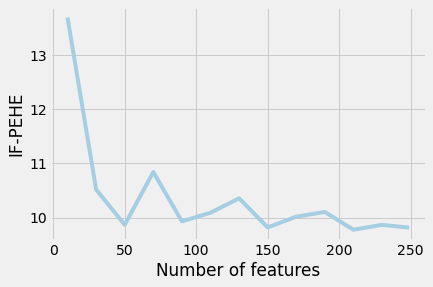

In [59]:
plt.plot(res_df['num_features'], res_df['IF-PEHE'])
plt.xlabel('Number of features')
plt.ylabel('IF-PEHE')

Text(0, 0.5, 'ERMSE')

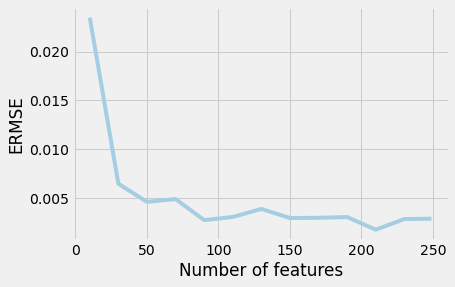

In [61]:
plt.plot(res_df['num_features'], res_df['ERMSE'])
plt.xlabel('Number of features')
plt.ylabel('ERMSE')

### KL divergence

In [25]:
method = 'KL'
f_imp = filter_f.get_importance(df_train0, x_names, y_name, method, 
                      treatment_group = 'treatment')

In [26]:
print(f_imp)

       method  feature   rank     score p_value               misc
0   KL filter      122    1.0  0.003821    None  number_of_bins: 4
0   KL filter      236    2.0  0.003021    None  number_of_bins: 2
0   KL filter       42    3.0  0.002762    None  number_of_bins: 2
0   KL filter      182    4.0  0.002760    None  number_of_bins: 3
0   KL filter      201    5.0  0.002700    None  number_of_bins: 3
..        ...      ...    ...       ...     ...                ...
0   KL filter      115  171.0  0.000000    None  number_of_bins: 1
0   KL filter      116  171.0  0.000000    None  number_of_bins: 1
0   KL filter      248  171.0  0.000000    None  number_of_bins: 1
0   KL filter       69  248.0 -0.000005    None  number_of_bins: 2
0   KL filter      216  249.0 -0.000008    None  number_of_bins: 2

[249 rows x 6 columns]


In [27]:
f_imp[f_imp['rank'] <= 10]

,method,feature,rank,score,p_value,misc
0,KL filter,122,1.0,0.003821,None,number_of_bins: 4
0,KL filter,236,2.0,0.003021,None,number_of_bins: 2
0,KL filter,42,3.0,0.002762,None,number_of_bins: 2
0,KL filter,182,4.0,0.002760,None,number_of_bins: 3
0,KL filter,201,5.0,0.002700,None,number_of_bins: 3
0,KL filter,67,6.0,0.002663,None,number_of_bins: 3
0,KL filter,20,7.0,0.002300,None,number_of_bins: 3
0,KL filter,242,8.0,0.002277,None,number_of_bins: 5
0,KL filter,74,9.0,0.001534,None,number_of_bins: 2
0,KL filter,195,10.0,0.001526,None,number_of_bins: 4


In [28]:
res_df = pd.DataFrame({'num_features': np.arange(10, 260, 20), 'ERMSE': np.arange(13), 'IF-PEHE': np.arange(13)})


for i in range(10, 250, 10):
    features = list(f_imp.loc[f_imp['rank'] <= i, 'feature'])
    x_temp_tr = df_train0[features]
    x_temp_te = df_test0[features]
    learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    learner_srf.fit(X=x_temp_tr,treatment=df_train0['treatment'],y=df_train0['adrd'])
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    test_cate_srf = test_learner_srf.fit_predict(X=x_temp_te,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    res_df.loc[res_df['num_features'] == i, 'ERMSE'] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
    
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=treatment_test)
    cate = cate_srf.flatten()
    plug_in = (t_plugin-cate)**2
    l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
    res_df.loc[res_df['num_features'] == i, 'IF-PEHE'] = (np.sum(l_de) + np.sum(plug_in))
    
# Add the evaluation of all features
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,treatment=df_test0['treatment'], y=df_test0['adrd'])

res_df.iloc[12, 0] = 249
res_df.iloc[12, 1] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)

cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
res_df.iloc[12, 2] = (np.sum(l_de) + np.sum(plug_in))

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5026
INFO:causalml:     AUC (Treatment):     0.5356
INFO:causalml:Log Loss   (Control):     0.3899
INFO:causalml:Log Loss (Treatment):     0.3183
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8656
INFO:causalml:     AUC (Treatment):     0.9097
INFO:causalml:Log Loss   (Control):     0.3339
INFO:causalml:Log Loss (Treatment):     0.2708
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5233
INFO:causalml:     AUC (Treatment):     0.5635
INFO:causalml:Log Loss   (Control):     0.3892
INFO:causalml:Log Loss (Treatment):     0.3184
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8980
INFO:causalml:     AUC (Treatment):     0.9054
INFO:causalml:Log Loss   (Control):     0.3167
INFO:causalml:Log Loss (Treatment):     0.2656
INFO:causalml:Error metrics for group treatment
INFO:cau

INFO:causalml:Log Loss (Treatment):     0.3233
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9759
INFO:causalml:     AUC (Treatment):     0.9880
INFO:causalml:Log Loss   (Control):     0.2440
INFO:causalml:Log Loss (Treatment):     0.2052
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5323
INFO:causalml:     AUC (Treatment):     0.5351
INFO:causalml:Log Loss   (Control):     0.3904
INFO:causalml:Log Loss (Treatment):     0.3233
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9759
INFO:causalml:     AUC (Treatment):     0.9880
INFO:causalml:Log Loss   (Control):     0.2440
INFO:causalml:Log Loss (Treatment):     0.2052
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5323
INFO:causalml:     AUC (Treatment):     0.5351
INFO:causalml:Log Loss   (Control):     0.3904
INFO:causalml:Log Loss (Treatment):     0.3233
INFO:caus

In [ ]:
plt.plot(res_df['num_features'], res_df['ERMSE'])
plt.xlabel('Number of features')
plt.ylabel('ERMSE')

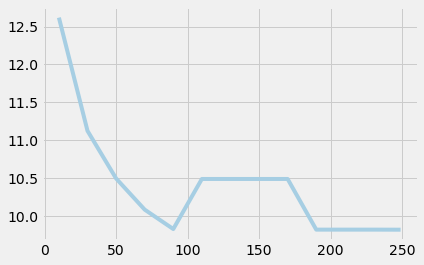

In [177]:
plt.plot(res_df['num_features'], res_df['IF-PEHE'])
plt.xlabel('Number of features')
plt.ylabel('PEHE')

In [178]:
res_df2 = pd.DataFrame({'num_features': np.arange(70, 112, 2), 'ERMSE': np.arange(21), 'IF-PEHE': np.arange(21)})


for i in range(70, 110, 2):
    features = list(f_imp.loc[f_imp['rank'] <= i, 'feature'])
    x_temp_tr = df_train0[features]
    x_temp_te = df_test0[features]
    learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    learner_srf.fit(X=x_temp_tr,treatment=df_train0['treatment'],y=df_train0['adrd'])
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    test_cate_srf = test_learner_srf.fit_predict(X=x_temp_te,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    res_df2.loc[res_df2['num_features'] == i, 'ERMSE'] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
    
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=treatment_test)
    cate = cate_srf.flatten()
    plug_in = (t_plugin-cate)**2
    l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
    res_df2.loc[res_df2['num_features'] == i, 'IF-PEHE'] = (np.sum(l_de) + np.sum(plug_in))
    
# Add the evaluation of all features
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,treatment=df_test0['treatment'], y=df_test0['adrd'])

res_df2.iloc[20, 0] = 249
res_df2.iloc[20, 1] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)

cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
res_df2.iloc[20, 2] = (np.sum(l_de) + np.sum(plug_in))

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5269
INFO:causalml:     AUC (Treatment):     0.5477
INFO:causalml:Log Loss   (Control):     0.3908
INFO:causalml:Log Loss (Treatment):     0.3222
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9530
INFO:causalml:     AUC (Treatment):     0.9524
INFO:causalml:Log Loss   (Control):     0.3004
INFO:causalml:Log Loss (Treatment):     0.2567
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5289
INFO:causalml:     AUC (Treatment):     0.6199
INFO:causalml:Log Loss   (Control):     0.3898
INFO:causalml:Log Loss (Treatment):     0.3197
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9497
INFO:causalml:     AUC (Treatment):     0.9529
INFO:causalml:Log Loss   (Control):     0.3048
INFO:causalml:Log Loss (Treatment):     0.2575
INFO:causalml:Error metrics for group treatment
INFO:cau

INFO:causalml:Log Loss (Treatment):     0.3216
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9594
INFO:causalml:     AUC (Treatment):     0.9871
INFO:causalml:Log Loss   (Control):     0.2784
INFO:causalml:Log Loss (Treatment):     0.2223
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5349
INFO:causalml:     AUC (Treatment):     0.5146
INFO:causalml:Log Loss   (Control):     0.3906
INFO:causalml:Log Loss (Treatment):     0.3216
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9594
INFO:causalml:     AUC (Treatment):     0.9871
INFO:causalml:Log Loss   (Control):     0.2784
INFO:causalml:Log Loss (Treatment):     0.2223
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5349
INFO:causalml:     AUC (Treatment):     0.5146
INFO:causalml:Log Loss   (Control):     0.3906
INFO:causalml:Log Loss (Treatment):     0.3216
INFO:caus

In [179]:
res_df2

,num_features,ERMSE,IF-PEHE
0,70,0.004792,10.081971
1,72,0.004150,10.283270
2,74,0.003434,10.150499
3,76,0.005311,10.632740
4,78,0.003891,10.078368
5,80,0.004787,9.893717
6,82,0.003555,10.159403
7,84,0.002799,9.854576
8,86,0.003162,10.060695
9,88,0.004060,9.962977


In [126]:
res_df = pd.DataFrame({'num_features': np.arange(82, 86, 1), 'ERMSE': np.arange(4), 'IF-PEHE': np.arange(4)})


for i in range(82, 86, 1):
    features = list(f_imp.loc[f_imp['rank'] <= i, 'feature'])
    x_temp_tr = df_train0[features]
    x_temp_te = df_test0[features]
    learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    learner_srf.fit(X=x_temp_tr,treatment=df_train0['treatment'],y=df_train0['adrd'])
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    test_cate_srf = test_learner_srf.fit_predict(X=x_temp_te,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    res_df.loc[res_df['num_features'] == i, 'ERMSE'] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
    
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=treatment_test)
    cate = cate_srf.flatten()
    plug_in = (t_plugin-cate)**2
    l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
    res_df.loc[res_df['num_features'] == i, 'IF-PEHE'] = (np.sum(l_de) + np.sum(plug_in))

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5381
INFO:causalml:     AUC (Treatment):     0.5113
INFO:causalml:Log Loss   (Control):     0.3896
INFO:causalml:Log Loss (Treatment):     0.3220
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9613
INFO:causalml:     AUC (Treatment):     0.9417
INFO:causalml:Log Loss   (Control):     0.3002
INFO:causalml:Log Loss (Treatment):     0.2604
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5045
INFO:causalml:     AUC (Treatment):     0.5646
INFO:causalml:Log Loss   (Control):     0.3916
INFO:causalml:Log Loss (Treatment):     0.3215
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9550
INFO:causalml:     AUC (Treatment):     0.9500
INFO:causalml:Log Loss   (Control):     0.3020
INFO:causalml:Log Loss (Treatment):     0.2566
INFO:causalml:Error metrics for group treatment
INFO:cau

In [127]:
res_df

,num_features,ERMSE,IF-PEHE
0,82,0.003555,64.103759
1,83,0.003515,22.700056
2,84,0.002799,49.889919
3,85,0.003410,60.334229


### ED

In [29]:
method = 'ED'
f_imp = filter_f.get_importance(df_train0, x_names, y_name, method, 
                      treatment_group = 'treatment')

In [30]:
print(f_imp)

       method  feature   rank         score p_value               misc
0   ED filter      122    1.0  1.642579e-03    None  number_of_bins: 4
0   ED filter      182    2.0  1.208062e-03    None  number_of_bins: 3
0   ED filter       42    3.0  1.182887e-03    None  number_of_bins: 2
0   ED filter      201    4.0  1.146721e-03    None  number_of_bins: 3
0   ED filter       67    5.0  1.111927e-03    None  number_of_bins: 3
..        ...      ...    ...           ...     ...                ...
0   ED filter      115  172.0  0.000000e+00    None  number_of_bins: 1
0   ED filter      116  172.0  0.000000e+00    None  number_of_bins: 1
0   ED filter      117  172.0  0.000000e+00    None  number_of_bins: 1
0   ED filter      248  172.0  0.000000e+00    None  number_of_bins: 1
0   ED filter      112  249.0 -1.019065e-07    None  number_of_bins: 2

[249 rows x 6 columns]


In [31]:
res_df_ed = pd.DataFrame({'num_features': np.arange(10, 260, 20), 'ERMSE': np.arange(13), 'IF-PEHE': np.arange(13)})


for i in range(10, 250, 10):
    features = list(f_imp.loc[f_imp['rank'] <= i, 'feature'])
    x_temp_tr = df_train0[features]
    x_temp_te = df_test0[features]
    learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    learner_srf.fit(X=x_temp_tr,treatment=df_train0['treatment'],y=df_train0['adrd'])
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    test_cate_srf = test_learner_srf.fit_predict(X=x_temp_te,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    res_df_ed.loc[res_df_ed['num_features'] == i, 'ERMSE'] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
    
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=treatment_test)
    cate = cate_srf.flatten()
    plug_in = (t_plugin-cate)**2
    l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
    res_df_ed.loc[res_df_ed['num_features'] == i, 'IF-PEHE'] = (np.sum(l_de) + np.sum(plug_in))
    
# Add the evaluation of all features
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,treatment=df_test0['treatment'], y=df_test0['adrd'])

res_df_ed.iloc[12, 0] = 249
res_df_ed.iloc[12, 1] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)

cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
res_df_ed.iloc[12, 2] = (np.sum(l_de) + np.sum(plug_in))

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5199
INFO:causalml:     AUC (Treatment):     0.5562
INFO:causalml:Log Loss   (Control):     0.3891
INFO:causalml:Log Loss (Treatment):     0.3178
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8675
INFO:causalml:     AUC (Treatment):     0.9152
INFO:causalml:Log Loss   (Control):     0.3343
INFO:causalml:Log Loss (Treatment):     0.2699
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5365
INFO:causalml:     AUC (Treatment):     0.5962
INFO:causalml:Log Loss   (Control):     0.3880
INFO:causalml:Log Loss (Treatment):     0.3180
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8922
INFO:causalml:     AUC (Treatment):     0.9040
INFO:causalml:Log Loss   (Control):     0.3199
INFO:causalml:Log Loss (Treatment):     0.2683
INFO:causalml:Error metrics for group treatment
INFO:cau

INFO:causalml:Log Loss (Treatment):     0.3237
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9805
INFO:causalml:     AUC (Treatment):     0.9919
INFO:causalml:Log Loss   (Control):     0.2518
INFO:causalml:Log Loss (Treatment):     0.2116
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5424
INFO:causalml:     AUC (Treatment):     0.5349
INFO:causalml:Log Loss   (Control):     0.3908
INFO:causalml:Log Loss (Treatment):     0.3237
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9805
INFO:causalml:     AUC (Treatment):     0.9919
INFO:causalml:Log Loss   (Control):     0.2518
INFO:causalml:Log Loss (Treatment):     0.2116
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5424
INFO:causalml:     AUC (Treatment):     0.5349
INFO:causalml:Log Loss   (Control):     0.3908
INFO:causalml:Log Loss (Treatment):     0.3237
INFO:caus

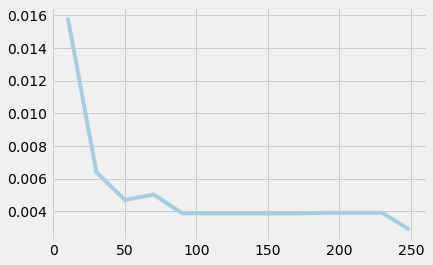

In [183]:
plt.plot(res_df['num_features'], res_df['ERMSE'])

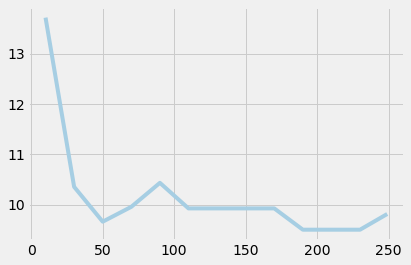

In [184]:
plt.plot(res_df['num_features'], res_df['IF-PEHE'])

In [185]:
res_df

,num_features,ERMSE,IF-PEHE
0,10,0.015859,13.713256
1,30,0.006403,10.355873
2,50,0.004697,9.664238
3,70,0.005036,9.959052
4,90,0.003890,10.434812
5,110,0.003875,9.927695
6,130,0.003875,9.927695
7,150,0.003875,9.927695
8,170,0.003875,9.927695
9,190,0.003918,9.505138


### Chi

In [32]:
method = 'Chi'
f_imp = filter_f.get_importance(df_train0, x_names, y_name, method, 
                      treatment_group = 'treatment')
res_df_chi = pd.DataFrame({'num_features': np.arange(10, 260, 20), 'ERMSE': np.arange(13), 'IF-PEHE': np.arange(13)})


for i in range(10, 250, 10):
    features = list(f_imp.loc[f_imp['rank'] <= i, 'feature'])
    x_temp_tr = df_train0[features]
    x_temp_te = df_test0[features]
    learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    learner_srf.fit(X=x_temp_tr,treatment=df_train0['treatment'],y=df_train0['adrd'])
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
    test_cate_srf = test_learner_srf.fit_predict(X=x_temp_te,
                treatment=df_test0['treatment'], y=df_test0['adrd'])
    
    res_df_chi.loc[res_df_chi['num_features'] == i, 'ERMSE'] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
    
    cate_srf = learner_srf.predict(X=x_temp_te, treatment=treatment_test)
    cate = cate_srf.flatten()
    plug_in = (t_plugin-cate)**2
    l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
    res_df_chi.loc[res_df_chi['num_features'] == i, 'IF-PEHE'] = (np.sum(l_de) + np.sum(plug_in))
    
# Add the evaluation of all features
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
    
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,treatment=df_test0['treatment'], y=df_test0['adrd'])

res_df_chi.iloc[12, 0] = 249
res_df_chi.iloc[12, 1] = ((cate_srf-test_cate_srf)**2).mean()**(1/2)
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)

cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
res_df_chi.iloc[12, 2] = (np.sum(l_de) + np.sum(plug_in))

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5125
INFO:causalml:     AUC (Treatment):     0.5454
INFO:causalml:Log Loss   (Control):     0.3894
INFO:causalml:Log Loss (Treatment):     0.3178
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8528
INFO:causalml:     AUC (Treatment):     0.9060
INFO:causalml:Log Loss   (Control):     0.3358
INFO:causalml:Log Loss (Treatment):     0.2664
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5359
INFO:causalml:     AUC (Treatment):     0.5884
INFO:causalml:Log Loss   (Control):     0.3885
INFO:causalml:Log Loss (Treatment):     0.3170
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9010
INFO:causalml:     AUC (Treatment):     0.9031
INFO:causalml:Log Loss   (Control):     0.3178
INFO:causalml:Log Loss (Treatment):     0.2679
INFO:causalml:Error metrics for group treatment
INFO:cau

INFO:causalml:Log Loss (Treatment):     0.3241
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9758
INFO:causalml:     AUC (Treatment):     0.9882
INFO:causalml:Log Loss   (Control):     0.2460
INFO:causalml:Log Loss (Treatment):     0.2069
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5323
INFO:causalml:     AUC (Treatment):     0.5044
INFO:causalml:Log Loss   (Control):     0.3909
INFO:causalml:Log Loss (Treatment):     0.3241
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9758
INFO:causalml:     AUC (Treatment):     0.9882
INFO:causalml:Log Loss   (Control):     0.2460
INFO:causalml:Log Loss (Treatment):     0.2069
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5323
INFO:causalml:     AUC (Treatment):     0.5044
INFO:causalml:Log Loss   (Control):     0.3909
INFO:causalml:Log Loss (Treatment):     0.3241
INFO:caus

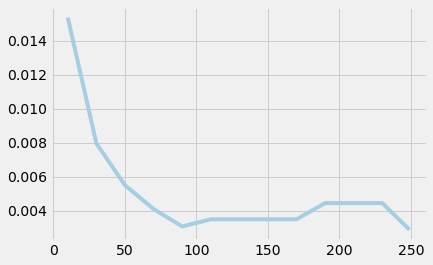

In [187]:
plt.plot(res_df['num_features'], res_df['ERMSE'])

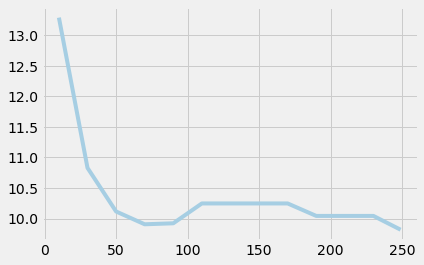

In [189]:
plt.plot(res_df['num_features'], res_df['IF-PEHE'])

In [190]:
res_df

,num_features,ERMSE,IF-PEHE
0,10,0.015347,13.291155
1,30,0.007955,10.829440
2,50,0.005495,10.114903
3,70,0.004099,9.905261
4,90,0.003074,9.921626
5,110,0.003494,10.246745
6,130,0.003494,10.246745
7,150,0.003494,10.246745
8,170,0.003494,10.246745
9,190,0.004447,10.042480


### Multiple plots

[Text(0.5, 0, 'Number of features')]

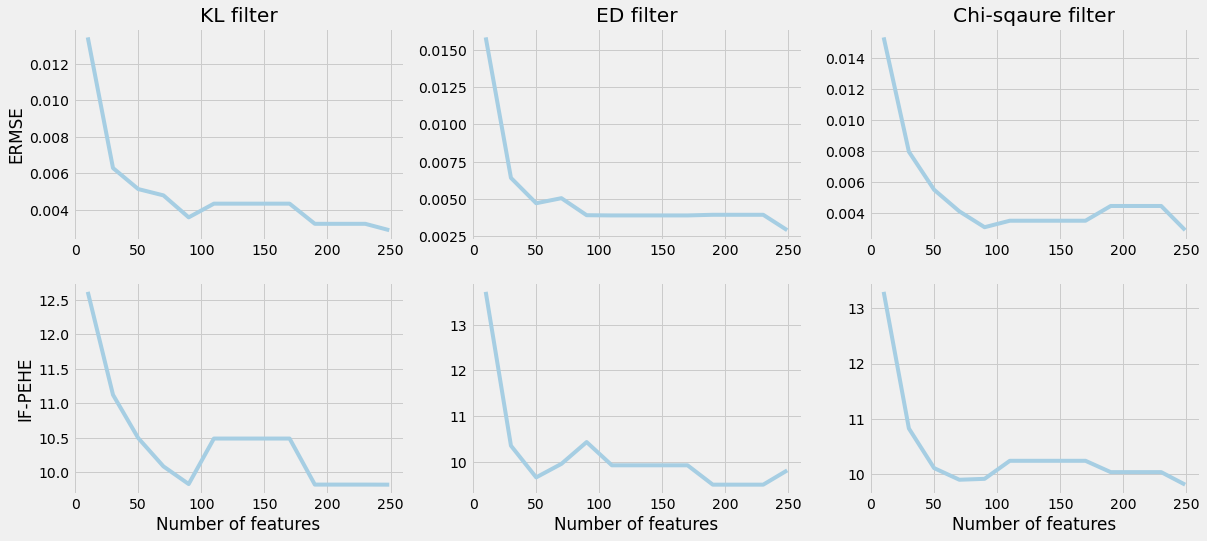

In [41]:
from matplotlib.pyplot import figure

fig, axs = plt.subplots(2, 3, figsize=(18,8))
axs[0, 0].plot(res_df['num_features'], res_df['ERMSE'])
axs[0, 0].set_title('KL filter')
axs[0, 0].set(ylabel='ERMSE')
axs[0, 1].plot(res_df_ed['num_features'], res_df_ed['ERMSE'])
axs[0, 1].set_title('ED filter')
#axs[0, 2].set(xlabel='Number of features', ylabel='ERMSE')
axs[0, 2].plot(res_df_chi['num_features'], res_df_chi['ERMSE'])
axs[0, 2].set_title('Chi-sqaure filter')
#axs[0, 0].set(xlabel='Number of features', ylabel='ERMSE')
axs[1, 0].plot(res_df['num_features'], res_df['IF-PEHE'])
axs[1, 0].set(xlabel='Number of features', ylabel='IF-PEHE')
axs[1, 1].plot(res_df_ed['num_features'], res_df_ed['IF-PEHE'])
axs[1, 1].set(xlabel='Number of features')
axs[1, 2].plot(res_df_chi['num_features'], res_df_chi['IF-PEHE'])
axs[1, 2].set(xlabel='Number of features')

## Models trained with all the features

In [36]:
learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf.fit(X=x_train0,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [37]:
cate_srf = learner_srf.predict(X=x_test0, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_srf = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf = test_learner_srf.fit_predict(X=x_test0,
                treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5402
INFO:causalml:     AUC (Treatment):     0.5087
INFO:causalml:Log Loss   (Control):     0.3901
INFO:causalml:Log Loss (Treatment):     0.3245
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9805
INFO:causalml:     AUC (Treatment):     0.9902
INFO:causalml:Log Loss   (Control):     0.2564
INFO:causalml:Log Loss (Treatment):     0.2153


In [38]:
((cate_srf-test_cate_srf)**2).mean()**(1/2)

0.002882500517789479

## Models trained with selected features (p < 0.05)

In [41]:
x_train1 = df_train0[fet_nm_p005]
x_test1 = df_test0[fet_nm_p005]

In [42]:
learner_srf_p005 = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf_p005.fit(X=x_train1,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [43]:
cate_srf_p005 = learner_srf_p005.predict(X=x_test1, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_srf_p005 = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf_p005 = test_learner_srf_p005.fit_predict(X=x_test1,
                treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5301
INFO:causalml:     AUC (Treatment):     0.5087
INFO:causalml:Log Loss   (Control):     0.3922
INFO:causalml:Log Loss (Treatment):     0.3244
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.8047
INFO:causalml:     AUC (Treatment):     0.8773
INFO:causalml:Log Loss   (Control):     0.3504
INFO:causalml:Log Loss (Treatment):     0.2753


In [45]:
((cate_srf_p005-test_cate_srf_p005)**2).mean()**(1/2)

0.022545722349253002

## Models trained with selected features (score > 1)

In [46]:
x_train_s1 = df_train0[fet_nm_s1]
x_test_s1 = df_test0[fet_nm_s1]

In [47]:
learner_srf_s1 = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
learner_srf_s1.fit(X=x_train_s1,treatment=df_train0['treatment'],y=df_train0['adrd'])

In [49]:
cate_srf_s1 = learner_srf_s1.predict(X=x_test_s1, treatment=df_test0['treatment'], y=df_test0['adrd'])
test_learner_srf_s1 = BaseSClassifier(learner=RandomForestClassifier(max_depth=6, random_state=1105), control_name='control')
test_cate_srf_s1 = test_learner_srf.fit_predict(X=x_test_s1,
                treatment=df_test0['treatment'], y=df_test0['adrd'])

INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.5258
INFO:causalml:     AUC (Treatment):     0.5314
INFO:causalml:Log Loss   (Control):     0.3925
INFO:causalml:Log Loss (Treatment):     0.3246
INFO:causalml:Error metrics for group treatment
INFO:causalml:     AUC   (Control):     0.9403
INFO:causalml:     AUC (Treatment):     0.9307
INFO:causalml:Log Loss   (Control):     0.3223
INFO:causalml:Log Loss (Treatment):     0.2697


In [51]:
((cate_srf_s1-test_cate_srf_s1)**2).mean()**(1/2)

0.004381184804925557

# IF-PEHE evaluation

In [39]:
y_test = df_test0['adrd']

In [160]:
xgb_plugin1 = XGBClassifier(max_depth=6, random_state=1105, n_estimators=100)
xgb_plugin0 = XGBClassifier(max_depth=6, random_state=1108, n_estimators=100)

In [161]:
x0 = df_train0.loc[df_train0['treatment'] == 'control', 0:248]
y0 = df_train0.loc[df_train0['treatment'] == 'control', 'adrd']

In [162]:
xgb_plugin0.fit(x0, y0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              random_state=1108, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [163]:
x1 = df_train0.loc[df_train0['treatment'] == 'treatment', 0:248]
y1 = df_train0.loc[df_train0['treatment'] == 'treatment', 'adrd']
y_pred1 = xgb_plugin1.fit(x1, y1)

In [164]:
y_pred0 = xgb_plugin0.predict(x_test0)
y_pred1 = xgb_plugin1.predict(x_test0)

In [165]:
t_plugin = y_pred1 - y_pred0

In [166]:
ps = rf.predict_proba(x_test0)[:, 1]

In [167]:
a = (treatment_test - ps)

In [168]:
ident = np.array([1]*len(ps))
c = (ps*(ident-ps))

In [169]:
b = np.array([2]*len(treatment_test))*treatment_test*(treatment_test-ps) / c

# S-learner

In [170]:
cate_srf = learner_srf.predict(X=x_test0, treatment=treatment_test)
cate = cate_srf.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

9.816688026373683

In [68]:
cate_srf_p005 = learner_srf_p005.predict(X=x_test1, treatment=treatment_test)
cate = cate_srf_p005.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

14.320256632940335

In [69]:
cate_srf_s1 = learner_srf_s1.predict(X=x_test_s1, treatment=treatment_test)
cate = cate_srf_s1.flatten()
plug_in = (t_plugin-cate)**2
l_de = (ident - b) * t_plugin**2 + b*y_test*(t_plugin - cate) + (- a*(t_plugin - cate)**2 + cate**2)
(np.sum(l_de) + np.sum(plug_in))

10.496601694652181

In [88]:
len(np.arange(70, 112, 2))

21